# 3 - Introduction to Image Classification

In [1]:
# ! pip install tensorflow==2.2

import os
import tensorflow as tf #
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.2.0'

# 3.1 Convolutions

So far we have used data that doesn't have any inherent structure. For example, for the inputs vector $X = [x_1, x_2, x_3, x_4]$, the order of the $x$s doesn't really matter. We could train another model with a different order and expect the same results, only the corresponding $w$s would change to weight them as needed.

In constrast, data such as images (and even text!), have an explicit structure. We are looking for patterns that could correlate in two dimensions. To make it clearer what is meant by structure, look what happens to the following 28x28 pixel image when we unravel it into a single dimensional vector.

![structure data](./assets/structured_data.png)

The spatial correlations disappear! We could try to relearn the structure using the neural networks we have looked at so far, but it is a much harder problem. We therefore want to be able to preserve the original structure in the data. The way to do this is to have a set of weights which retain spatial relationships. This set of weights is called a **kernel** or a **filter** and looks like this:

![filter](./assets/filter.png)

Filters are at the heart of image processing. People once spent whole PhDs designing filters to transform images in particular ways. For example, the following filter is an **edge dectector** and just as in previous topics, the weights transform the image linearly, into a **weighted sum of the pixels in the 3x3 neighborhood**. 

![edge_detector](./assets/edge_detector.png)


When moved across an image in a sliding-window fashsion the transformation reveals the edges of the image.

<br>

![convolution](./assets/convolution.gif)

<br>

Convolutional Neural Networks (CNNs) take this idea, and go about **learning the weights** instead of specifying them in advanced. Combined with bias terms and non-linear activation functions, a CNN is composed of multiple convolutional layers (layers with filters) ptimized to discriminate features suitable for your dataset. This technology is enormously powerful. No-one knows how to design a filter that can discriminate between different dogs breeds, but we can now learn those filters easily. This is why the use of CNNs is now pervasive in image processing is increasingly the go-to technique in bio- and biomedical imaging.

To get started, let's now build a small CNN in `tensorflow` to classify 60,000 hand-written digits into 10 classes.


In [47]:
# Load the data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [48]:
# convert to one-hot
y_train = tf.keras.backend.one_hot(y_train, num_classes=10)
y_test = tf.keras.backend.one_hot(y_test, num_classes=10)

In [49]:
# add a channel dimensional to the images
old_shape = X_train.shape
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print(old_shape, "-->", X_train.shape)

(60000, 28, 28) --> (60000, 28, 28, 1)


The model will consist of 3 convolutional layers and then a `GlobalAvgPooling2D`, which takes the spatial average for each filter. These features will then be used for classification. To improve training speed we will also use the `relu` activation function, which stands for **Rectified Linear Unit**. This helps to ensure there are always useful gradients to learning with.

In [9]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [53]:
tf.keras.backend.clear_session()

# Model input --------- H   W   C
model_in = Input(shape=(28, 28, 1), name="CNN_Input")
# Connect 3 Convolutional Layers with 3x3 kernels, 
# and a sliding-window stride of 2 horizontal / 2 vertical
x = Conv2D(filters=12, kernel_size=(3,3), strides=(2,2),
           padding="same", activation="relu", name="Conv_1")(model_in)
x = Conv2D(filters=12, kernel_size=(3,3), strides=(2,2),
           padding="same", activation="relu", name="Conv_2")(x)
x = Conv2D(filters=12, kernel_size=(3,3), strides=(2,2),
           padding="same", activation="relu", name="Conv_3")(x)
# Spatial average for each filter
x = GlobalAveragePooling2D(name="Global_Pool")(x)
model_out = Dense(units=10, activation="softmax", name="CNN_Output")(x)
model = Model(inputs=[model_in], outputs=[model_out], name="CNN_Digits")

model.summary()

Model: "CNN_Digits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_Input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 14, 14, 12)        120       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 7, 7, 12)          1308      
_________________________________________________________________
Conv_3 (Conv2D)              (None, 4, 4, 12)          1308      
_________________________________________________________________
Global_Pool (GlobalAveragePo (None, 12)                0         
_________________________________________________________________
CNN_Output (Dense)           (None, 10)                130       
Total params: 2,866
Trainable params: 2,866
Non-trainable params: 0
______________________________________________________

We will big a better gradient descent algorithm called Adam using the cross entropy loss for multi-class classification.

In [8]:
from tensorflow.keras.optimizers import Adam

In [55]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["acc"])

We will now train using the `model.fit()` method and pick how many epochs to train for. An **epoch** refers to the model having been trained on the entire dataset. 5 epochs therefore means the model will see the entire dataset 5 times during training.

In [57]:
history = model.fit(x=X_train, y=y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7538 - acc: 0.7695
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2907 - acc: 0.9160
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2209 - acc: 0.9372
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1838 - acc: 0.9461
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1615 - acc: 0.9523


The `history` object contains a dictionary called `history` which stores the loss and accuracy metrics from training. 

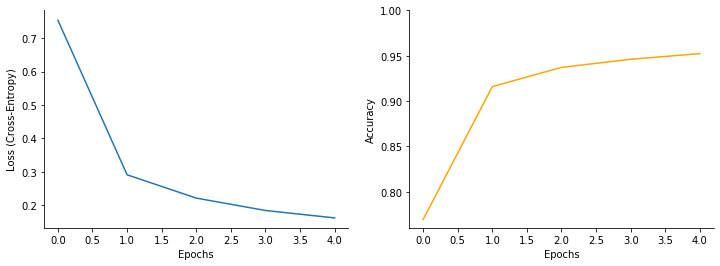

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(range(5), history.history["loss"])
ax[1].plot(range(5), history.history["acc"], color="orange")

ax[0].set_ylabel("Loss (Cross-Entropy)")
ax[0].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")

ax[1].set_ylim(top=1)

for a in ax:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)

plt.show()

As mentioned in the previous notebook, we need to **validate** our model on an unseen data set i.e. (`X_test`, `y_test`)

In [75]:
loss, acc = model.evaluate(x=X_test, y=y_test)
print("Validation Accuracy:", acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.1477 - acc: 0.9561
Validation Accuracy: 0.9560999870300293


This tells us that our model performs just as well on our test data as it does on our training data. This is exactly what we want! We can save the weights of our model (and load them) in `hd5` format as follows:

In [76]:
model.save_weights("./weights/digits_95.h5")
#model.load_weights("./weights/digits_95.h5")

# 3.2 Transfer Learning

One of the challenges of deep learning is the enormous amount of data required to avoid over-fitting on the training set. Although it depends on the problem, most imaging tasks will need a minimum of tens of thousands of images to train on. For many people that is just not possible.

Thankfully, a paradigm called **Transfer Learning** exists. It makes the assumption that weights useful for classifying images from one domain are also useful to another, and so can be transfered. In practice, it is common to see people using **pretrained networks** from the ImageNet Dataset (14 million images of everyday objects) and apply them to their problem. 

We will demonstrate this on a small dataset of skin cancer images, classifying them as either melanoma or nevus. We will use the `MobileNet2` pretrained network, a small but high-performing architecture. We will use the pretained network to **extract features** from the images, and then using those features train our own classification layer suitable to our problem.

![skin cancer](./assets/skin_cancer.png)

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Prepare Data

In [4]:
data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

train_gen = data_gen.flow_from_directory(directory="./data/skinCancer/",
                                         target_size=(128, 128),
                                         class_mode='binary',
                                         batch_size=12,
                                         seed=123,
                                         subset="training", 
)

val_gen = data_gen.flow_from_directory(directory="./data/skinCancer/",
                                         target_size=(128, 128),
                                         class_mode='binary',
                                         batch_size=12,
                                         seed=123,
                                         subset="validation", 
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Build Model

In [40]:
tf.keras.backend.clear_session()

In [41]:
mobile = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
# lock weights of mobile network
mobile.trainable = False

In [42]:
#mobile.summary()

In [43]:
model_in = Input(shape=(128, 128, 3), name="Input_Transfer_Learning")
# Extract features
x = mobile(model_in)
# Spatial Averageing
x = GlobalAveragePooling2D(name="GlobalPooling")(x)
# Classify
model_out = Dense(units=1, activation="sigmoid", name="Output_Transfer_Learning")(x)
# Build model
model = Model(inputs=[model_in], outputs=[model_out], name="Classifier_Transfer_Learning")
model.summary()

Model: "Classifier_Transfer_Learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Transfer_Learning (Inp [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 1280)              0         
_________________________________________________________________
Output_Transfer_Learning (De (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


We can see that there are over 2.2 million parameters in the `MobileNetv2`. Fortunately, we are only training 1,281 parameters. 

In [44]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["acc"])

In [45]:
history = model.fit(x=train_gen,
                    epochs=12,
                    steps_per_epoch=1600//12 # n // batchsize
                   )

Epoch 1/12
133/133 [==============================] - 7s 51ms/step - loss: 0.5343 - acc: 0.7393
Epoch 2/12
133/133 [==============================] - 7s 51ms/step - loss: 0.4216 - acc: 0.8023
Epoch 3/12
133/133 [==============================] - 7s 49ms/step - loss: 0.3839 - acc: 0.8287
Epoch 4/12
133/133 [==============================] - 6s 48ms/step - loss: 0.3700 - acc: 0.8350
Epoch 5/12
133/133 [==============================] - 7s 51ms/step - loss: 0.3548 - acc: 0.8401
Epoch 6/12
133/133 [==============================] - 7s 51ms/step - loss: 0.3264 - acc: 0.8602
Epoch 7/12
133/133 [==============================] - 7s 50ms/step - loss: 0.3105 - acc: 0.8665
Epoch 8/12
133/133 [==============================] - 7s 50ms/step - loss: 0.3252 - acc: 0.8583
Epoch 9/12
133/133 [==============================] - 7s 50ms/step - loss: 0.2769 - acc: 0.8873
Epoch 10/12
133/133 [==============================] - 6s 48ms/step - loss: 0.2770 - acc: 0.8898
Epoch 11/12
133/133 [==================

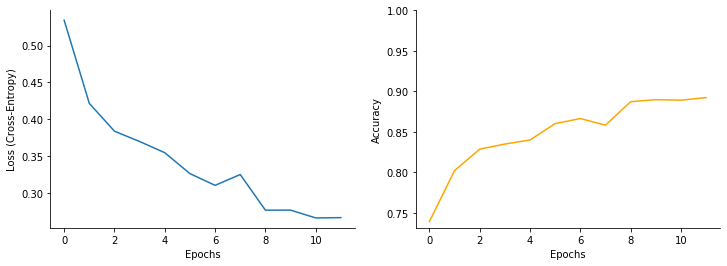

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(range(12), history.history["loss"])
ax[1].plot(range(12), history.history["acc"], color="orange")

ax[0].set_ylabel("Loss (Cross-Entropy)")
ax[0].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")

ax[1].set_ylim(top=1)

for a in ax:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)

plt.show()

We can finally validate our model on the unseen data set.

In [47]:
loss, acc = model.evaluate(x=val_gen, steps=400//12)
print("Validation Accuracy:", acc)

33/33 [==============================] - 2s 49ms/step - loss: 0.7960 - acc: 0.6439
Validation Accuracy: 0.6439393758773804


Both the loss and the accuracy metrics show us that there is a significant gap in performance between the training and validation data. This is a clear indication that we are over-fitting to the training data! We of course want to improve on this. In practice this is done via an iterative process, by using **regularisation techniques**, or **augmenting the training data**, or by **modifiying the archicture**, which will hopefully see the validation accuracy improve. However, in doing so, we are actually *tuning our network* to perform well on the validation set. This is **over-fitting on the validation set** and could lead to poor generalisability! Therefore, best practice in machine learning is to use the following data splits:

- **Training Split**: 70-90% of the data used to train the model
- **Validation Split**: 5-10% of the data used to improve generalisability
- **Test Split**: 5-10% of the data use to provide a final performance measure.

Importantly, the test split is only ever seen once, at the end of all the experiments.

In [ ]:
#model.save_weights("./weights/skin_64.h5")
#model.load_weights("./weights/skin_64.h5")

# Conclusion

Here you have learned about convolutional neural networks and why they are suitable for image data. Using tensorflow you can build them in a straight-forward manner but you should also take notice of how many ways they can be modified, such as number of layers, number of filters per layer, the filter size and stride size, the activation function to use, using global average pooling, or max pooling etc. There are so many things to change that may improve the performance on your data set. 

Obviously we need a lot of data to ensure good generalisability, and so a nice shortcut is to utilise transfer learning. Despite this, there is no substitute for good data, and the more time you spend on collecting, labeling and preparing the data, the better your chances of success.